<font size="4">

<h1> Đồ án cuối kì môn học sâu </h1>   
 
<h2> Học viên thực hiện: </h2>
    
- Lê Trần Thanh Phong - 20C11045
- Nguyễn Anh Tuấn - 20C11014
- Nguyễn Tống Đức Huy - 20C11031
- Phạm Thành - 20C11052
    
<h2> Giảng viên hướng dẫn: TS. Nguyễn Đức Huy </h2>

<h2> Hướng tiếp cận: </h2>
    
Nhóm xây dựng mô hình dựa trên các mô hình DenseNet121, EfficientNetB7, Inceptionv3, và Resnet152v2. <br/>
    
Các mô hình được huấn luyện trên 5 tập dữ liệu được tạo bằng kỹ thuật KFold. <br/>
    
Sau đó, các mô hình được ensemble lại để cho ra kết quả tốt nhất.
    
<h2> Kết quả: </h2>
    
Nhóm đạt được kết quả tốt nhất là 97.133% khi ensemble 5 model transfer learning trên EfficientNetB7.
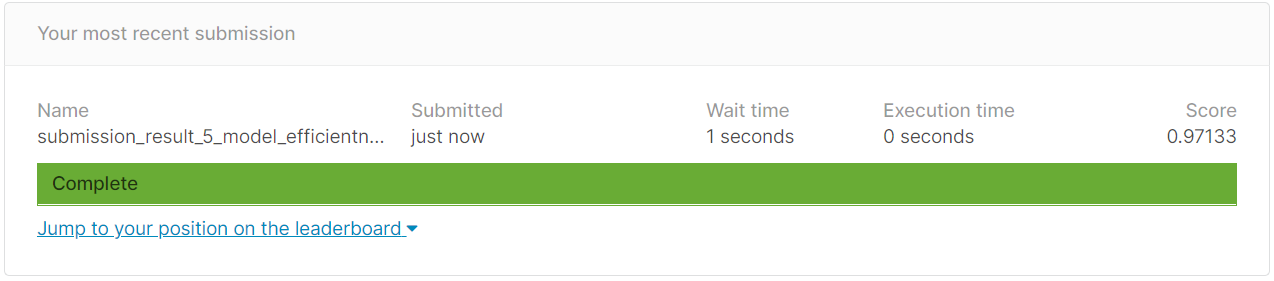
    
<h2> Mục lục: </h2>
1. Tiền xử lý và tạo tập dữ liệu <br/>
2. Huấn luyện mô hình <br/>
3. Ensemble các mô hình đã huấn luyện <br/>
</font>
==================================================================== ooo ====================================================================

In [ ]:
# Cài efficientnet để sử dụng bộ weight noisy-student (tensorflow.keras.applications không có bộ weight này)
!pip install -q efficientnet

In [ ]:
# Import các thư viện cần thiết
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets

# Các mô hình được sử dụng để huấn luyện tiếp
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras.applications import ResNet152V2

# Import các hàm phân chia tập train thành các tập train và test
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
# Định nghĩa đường dẫn tới tập dữ liệu
GCS_PATH = KaggleDatasets().get_gcs_path()

IMAGE_PATH = GCS_PATH + "/images/"
TEST_PATH = GCS_PATH + "/test.csv"
TRAIN_PATH = GCS_PATH + "/train.csv"
SUB_PATH = GCS_PATH + "/sample_submission.csv"

# Định nghĩa kích thước ảnh input vào mô hình
IMAGE_SIZE = (512, 512)
IMAGE_SIZE_WITH_CHANNEL = IMAGE_SIZE + (3,)

# Định nghĩa số lớp output đầu ra của mô hình
NUM_CLASS = 4

# Định nghĩa các tham số để huấn luyện mô hình
EPOCHS = 40
BATCH_SIZE = 16

In [ ]:
# Cấu hình để chạy trên TPU
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

STRATEGY_NUM_REPLICAS_IN_SYNC = strategy.num_replicas_in_sync
BATCH_SIZE = 16 * STRATEGY_NUM_REPLICAS_IN_SYNC

In [ ]:
# Cấu hình để lưu mô hình đã huấn luyện và kết quả trên Google Cloud.
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

<h1>Tiền xử lý và tạo tập dữ liệu</h1>

<h2> Tiền xử lý </h2>
<font size="4">
    
Để có thể huấn luyện hiệu quả, nhóm thực hiện các bước cơ bản để tiền xử lý các bức hình đưa vào mô hình,  như thay đổi kích thước bức hình về cùng một kích thước và tỉ lệ, chuẩn hoá các giá trị pixel về đoạn [0, 1]. <br/>
    
Và để tăng độ chính xác, nhóm cũng thực hiện các bước tăng cường dữ liệu (data augmentation) như xoay trái, xoay phải, lật lên, lật xuống.
</font>
<h2> Tạo tập dữ liệu </h2>
<font size="4">
    
Nhóm sử dụng kỹ thuật KFold để tạo 5 tập dữ liệu huấn luyện khác nhau. <br/>
    
Để tránh các tập dữ liệu được tạo bị bias thì nhóm sử dụng StratifiedKFold.<br/>
    
Với dữ liệu huấn luyện cho mô hình ensemble thì nhóm chỉ chia tập huấn luyện với tỉ lệ nhất định.
</font>

In [ ]:
# Định nghĩa lớp để đọc và tiền xử lý dữ liệu.
class Data():
    
    def __init__(self):
        # Đọc dữ liệu từ file csv.
        test_data = pd.read_csv(TEST_PATH)
        train_data = pd.read_csv(TRAIN_PATH)
        
        # Tạo tập dữ liệu đường dẫn tới các file hình
        self.test_paths = test_data.image_id.apply(self.get_image_path).values
        self.train_paths = train_data.image_id.apply(self.get_image_path).values
        
        # Tạo tập nhãn từ tập dữ liệu huấn luyện
        self.train_labels = np.float32(train_data.loc[:, 'healthy':].values)
        
    # Lấy đường dẫn tới file hình (trong csv chỉ định nghĩa tên hình)
    def get_image_path(self, image_name):
        return IMAGE_PATH + image_name + '.jpg'
    
    # Xử lý bức hình
    def process_image(self, filename, label=None):
        bits = tf.io.read_file(filename)
        
        # Mã hoá hình thành 8 bit integer tensor
        image = tf.image.decode_jpeg(bits, channels=3)
        
        # Chuyển 8 bit integer tensor qua kiểu float32
        # Sau đó chia cho 255 để đơn giản việc tính toán và huấn luyện nhanh hơn
        image = tf.cast(image, tf.float32) / 255.0
        
        # Resize hình về kích thước (512, 512) của input mô hình vì kích thước ảnh trong tập dataset là 2048 x 1365
        # Ở đây có thể resize về nhiều kích thước khác nhau, không nhất thiết phải (512, 512)
        image = tf.image.resize(image, IMAGE_SIZE)
        
        if label is None:
            # Trả kết quả cho tập test không có label
            return image
        else:
            # Trả kết quả cho tập train và tập validate
            return image, label

    # Xoay hình để mô hình có thể nhận biết được nhiều dạng không có trong tập huấn luyện
    def rotate_image(self, image, label=None):
        # Lật ngẫu nhiên trái, phải
        image = tf.image.random_flip_left_right(image)
        
        # Lật ngẫu nhiên lên, xuống
        image = tf.image.random_flip_up_down(image)
        
        if label is None:
            # Trả kết quả cho tập test không có label
            return image
        else:
            # Trả kết quả cho tập train và tập validate
            return image, label
        
    # Tạo tập dữ liệu huấn luyện dựa trên kỹ thuật KFold    
    def get_train_kfold_dataset(self):
        kfold_dataset = []
        
        # Tạo 5 fold
        kf = StratifiedKFold(n_splits=5)
        
        # Tạo tập train và validate cho từng fold
        for fold_index, (train_index, val_index) in enumerate(kf.split(self.train_paths, self.train_labels.argmax(1))):
            kfx_train, kfy_train = self.train_paths[train_index], self.train_labels[train_index]
            kfx_val, kfy_val = self.train_paths[val_index], self.train_labels[val_index]
            
            # Tạo tập dữ liệu train và chạy các bước tiền xử lý
            train_dataset = (
                tf.data.Dataset.from_tensor_slices((kfx_train, kfy_train))
                .map(self.process_image, num_parallel_calls=AUTO)
                .map(self.rotate_image, num_parallel_calls=AUTO)
                .repeat().shuffle(512).batch(BATCH_SIZE).prefetch(AUTO)
            )
            
            # Tạo tập dữ liệu validate và chạy các bước tiền xử lý
            valid_dataset = (
                tf.data.Dataset.from_tensor_slices((kfx_val, kfy_val))
                .map(self.process_image, num_parallel_calls=AUTO)
                .batch(BATCH_SIZE).cache().prefetch(AUTO)
            )
            
            kfold_dataset.append((train_dataset, valid_dataset))
        
        return kfold_dataset
  
    # Tạo tập dữ liệu để ensemble
    def get_split_dataset(self):
        train_paths, val_paths, y_train, y_val = train_test_split(self.train_paths, self.train_labels, test_size=0.15, random_state=2048)
    
        # Tạo tập dữ liệu train và chạy các bước tiền xử lý
        x_train = (
            tf.data.Dataset.from_tensor_slices(train_paths)
            .map(self.process_image, num_parallel_calls=AUTO)
            .map(self.rotate_image, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE).prefetch(AUTO)
        )

        return (x_train, y_train)
    
    # Tạo tập dữ liệu để test
    def get_test_dataset(self):
        # Tạo tập dữ liệu test và chạy các bước tiền xử lý
        test_dataset = (
                tf.data.Dataset.from_tensor_slices(self.test_paths)
                .map(self.process_image, num_parallel_calls=AUTO)
                .batch(BATCH_SIZE)
            )
        
        return test_dataset
    
    def get_label_len(self):
        return len(self.train_labels)

<h1> Huấn luyện mô hình</h1>

<h2> Khởi tạo mô hình</h2>
<font size="4">
    
Nhóm sử dụng transfer learning để huấn luyện 4 mô hình DenseNet121, EfficientNetB7, Inceptionv3, và Resnet152v2 trên dữ liệu plant-pathology-2020-fgvc7. <br/>
    
Mô hình gồm 3 lớp: lớp mô hình pretrain, lớp global average pooling, và lớp softmax. <br/>
    
Mô hình output ra 4 nhãn tương ứng với: healthy, multiple_diseases, rust, và scab. <br/>
    
Bộ optimizer Adam được sử dụng để huấn luyện mô hình cùng với hàm loss cross entropy.
</font>

<h2> Huấn luyện mô hình</h2>
<font size="4">
    
Mô hình được huấn luyện trên 40 epoch và với batch size bằng 16 x số TPU, trên 5 tập dữ liệu được tạo từ KFold cho 4 mô hình DenseNet121, EfficientNetB7, Inceptionv3, và Resnet152v2. Trọng số của các mô hình pretrain được huấn luyện tiếp chứ không bị đóng băng. <br/>
    
Mô hình densenet121, inceptionv3, và resnet152v2 sử dụng bộ trọng số "image-net", còn efficientnet sử dụng bộ trọng số "noisy-student".
</font>
<h2> Test mô hình</h2>
<font size="4">
    
Từng mô hình được chạy trên tập test để kiểm tra kết quả trên kaggle trước khi ensemble. Các mô hình có kết quả thấp sẽ không được ensemble.  <br/>
    
Các mô hình có độ chính xác giao động vào khoảng 94% đến 96%. Mô hình EfficientNet cho ra độ chính xác cao nhất cho từng mô hình riêng lẻ.
</font>

In [ ]:
# Định nghĩa bộ scheduler cho learning rate để sử dụng cho thuật toán optimizer Adam.
# Learning rate sẽ được thay đổi dựa trên số epoch đã chạy được. 
class LearningRateScheduler:
    def __init__(self, lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
        self.lr_start=lr_start
        self.lr_max=lr_max * STRATEGY_NUM_REPLICAS_IN_SYNC
        self.lr_min=lr_min
        self.lr_rampup_epochs=lr_rampup_epochs
        self.lr_sustain_epochs=lr_sustain_epochs
        self.lr_exp_decay=lr_exp_decay
        
    def scheduler(self, epoch):
        if epoch < self.lr_rampup_epochs:
            lr = (self.lr_max - self.lr_start) / self.lr_rampup_epochs * epoch + self.lr_start
        elif epoch < self.lr_rampup_epochs + self.lr_sustain_epochs:
            lr = self.lr_max
        else:
            lr = (self.lr_max - self.lr_min) *\
                 self.lr_exp_decay**(epoch - self.lr_rampup_epochs\
                                - self.lr_sustain_epochs) + self.lr_min
        return lr
        
    def get_learning_rate_scheduler(self):
        return tf.keras.callbacks.LearningRateScheduler(self.scheduler, verbose=1) 

In [ ]:
# Định nghĩa hàm huấn luyện mô hình.
# Input đầu vào gồm mô hình pretrain, tập dữ liệu huấn luyện, tập dữ liệu validate và số fold của tập dữ liệu đó
def train(pretrain_model, train_dataset, valid_dataset, fold_index):
    # Tạo mô hình để transfer learning.
    model = tf.keras.Sequential([pretrain_model,
                                 layers.GlobalAveragePooling2D(),
                                 layers.Dense(NUM_CLASS,
                                         activation='softmax')])

    # Khai báo các tham số để huấn luyện mô hình
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

    model_name = pretrain_model.name + "_" + str(fold_index)
    checkpoint_path = "gs://gs_hocsau_final_project/{}/checkpoints".format(model_name)
    
    # Khai báo callback để lưu checkpoint lúc huấn luyện mô hình
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True)

    # Huấn luyện mô hình
    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        callbacks=[base_scheduler.get_learning_rate_scheduler(), checkpoint_callback],
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_dataset)

    # Lưu mô hình
    model.save("gs://gs_hocsau_final_project/{}".format(model_name))

In [ ]:
# Khởi tạo tập dữ liệu và các tham số cần thiết để huấn luyện mô hình
data = Data()
kfold_dataset = data.get_train_kfold_dataset()
steps_per_epoch = data.get_label_len() // BATCH_SIZE
base_scheduler = LearningRateScheduler()

In [ ]:
# Lần lượt huấn luyện các mô hình với các tập dữ liệu được tạo từ KFold.
with strategy.scope():
    model_pool = {
             DenseNet121(input_shape=IMAGE_SIZE_WITH_CHANNEL, weights='imagenet', include_top=False),
             InceptionV3(input_shape=IMAGE_SIZE_WITH_CHANNEL, weights='imagenet', include_top=False),
             EfficientNetB7(input_shape=IMAGE_SIZE_WITH_CHANNEL, weights='noisy-student', include_top=False),
             ResNet152V2(input_shape=IMAGE_SIZE_WITH_CHANNEL, weights='imagenet', include_top=False),
             }
    for model in model_pool:
        fold_index = 0
        for train_dataset, valid_dataset in kfold_dataset:
            train(model, train_dataset, valid_dataset, fold_index)
            fold_index += 1

In [ ]:
# Chuẩn bị các tập dữ liệu để ensemble và test mô hình
(x_train, y_train) = data.get_split_dataset()
test_dataset = data.get_test_dataset()

In [ ]:
# Dự đoán sử dụng 5 mô hình transfer learning với efficientnet-b7
with strategy.scope():
    predicted_models = predict_models(test_dataset, ['efficientnet-b7'])

In [ ]:
# Xuất kết quả cho 5 mô hình transfer learning với efficientnet-b7
for i in range(5):
    preds = predicted_models[i]
    sub = pd.read_csv(SUB_PATH)
    sub.loc[:, 'healthy':] = preds
    sub.to_csv('gs://gs_hocsau_final_project/submission_result_efficientnet-b7_v2_{}.csv'.format(i), index=False)
    sub.head()

<h1> Ensemble các mô hình đã huấn luyện</h1>

<font size="4">
    
Nhóm sử dụng 3 phương pháp ensemble là **Average Ensemble, Weighted Average Ensemble, và Stacked Ensemble**. <br/>
    
Mặc dù Stacked Ensemble tốt hơn 2 phương pháp còn lại vì sử dụng mạng neuron để xác định trọng số nhưng nhóm nhận thấy, trong 3 phương pháp này thì Weighted Average Ensemble cho ra kết quả tốt nhất, theo sau là Average Ensemble, và thấp nhất là Stacked Ensemble. Qua kết quả này có thể thấy tập huấn luyện cho mô hình của Stacked Ensemble vẫn thiếu độ đa dạng đặc trưng để cho ra kết quả tốt nhất. <br/>
    
Với phương pháp Average Ensemble, kết quả dự đoán của các mô hình được cộng lại và chia tổng số mô hình để lấy trung bình. Kết quả của phương pháp này cho ra độ chính xác 97.007%. <br/>
    
Với phương pháp Weighted Average Ensemble, kết quả dự đoán của các mô hình được nhân với bộ trọng số định nghĩa trước và cộng lại để cho ra kết quả cuối cùng. Kết quả của phương pháp này cho ra độ chính xác 97.133%. <br/>
    
Với phương pháp Stacked Ensemble, kết quả dự đoán của các mô hình được stack lại và đưa vào một mạng neuron để cho ra một dự đoán tổng hợp của các mô hình. Kết quả của phương pháp này cho ra độ chính xác 96.1% <br/>

Nhóm cũng thử ensemble các tổ hợp mô hình khác nhau như 5 EfficientNet, 5 Resnet... hay 5 EfficientNet + 5 Resnet + 5 Inception + 5 DenseNet. Hầu hết các mô hình ensemble này cho ra độ chính xác từ 96% đến 97%. 
</font>


In [ ]:
# Ensemble sử dụng phương pháp lấy trung bình
preds = None

for pred in predicted_models:
    if preds is None:
        preds = pred
    else:
        preds = preds + pred
        
preds = preds / len(predicted_models)
        
sub = pd.read_csv(SUB_PATH)
sub.loc[:, 'healthy':] = preds
sub.to_csv('gs://gs_hocsau_final_project/submission_result_efficientnet-b7_v2_average.csv'.format(i), index=False)
sub.head()

In [ ]:
# Ensemble với ma trận trọng số
weight_matrix = [0.2, 0, 0.2, 0.2, 0.4]
weighted_predicted_models = [predicted_models[i] * weight_matrix[i] for i in range(len(predicted_models))]

preds = None

for pred in weighted_predicted_models:
    if preds is None:
        preds = pred
    else:
        preds = preds + pred
        
sub = pd.read_csv(SUB_PATH)
sub.loc[:, 'healthy':] = preds
sub.to_csv('gs://gs_hocsau_final_project/submission_result_efficientnet-b7_v2_weighted.csv'.format(i), index=False)
sub.head()

In [ ]:
# Xuất các dự đoán để làm đầu vào cho mô hình ensemble
def predict_models(data, model_pool = ['densenet121', 'efficientnet-b7', 'inception_v3', 'resnet152v2']):
    predictions = []

    for model_name in model_pool:
        # Lần lượt duyệt qua 5 mô hình huấn luyện trên 5 fold
        for i in range(5):
            file_name = "{}_{}".format(model_name, i)
            
            # Load các mô hình đã huấn luyện lên
            model = tf.keras.models.load_model('gs://gs_hocsau_final_project/{}'.format(file_name))
            
            # Lưu lại các dự đoán của mô hình
            predictions.append(model.predict(data))
            
    return predictions

# Stack các dự đoán lại để đưa vào mô hình ensemble
def stacked_preds(predictions):
    x_train_preds = None

    for p in predictions:
        if x_train_preds is None:
            x_train_preds = p
        else:
            x_train_preds = np.dstack((x_train_preds, p))
            
    # Chuyển array 3 chiều thành array 2 chiều
    x_train_preds = x_train_preds.reshape(x_train_preds.shape[0], x_train_preds.shape[1] * x_train_preds.shape[2])

    return x_train_preds

# Huấn luyện mô hình ensemble
# Input đầu vào là các dự đoán cho các hình và các nhãn tương ứng
def train_ensemble(x_train_preds, y_train):
    # Kích thước input của mô hình ensemble là tổng các output của các mô hình
    inputs = layers.Input(x_train_preds.shape[1], dtype=tf.float32)
    dense = layers.Dense(x_train_preds.shape[1], activation='relu')(inputs)
    logits = layers.Dense(4, activation='softmax')(dense)
    ensemble_model = tf.keras.Model(inputs=[inputs], outputs=[logits])

    # Khai báo các tham số cần thiết để huấn luyện mô hình
    loss = tf.keras.losses.CategoricalCrossentropy()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.99,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    metrics = ['categorical_accuracy']
    ensemble_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    ensemble_model.summary()

    # Huấn luyện mô hình
    ensemble_model.fit(
        x_train_preds, y_train,
        batch_size=BATCH_SIZE, epochs=EPOCHS
    )
    
    return ensemble_model
    
# Xuất kết quả dự đoán của mô hình ensemble
def test_ensemble(ensemble_model, data, file_name='submission_result_ensemble'):
    result = ensemble_model.predict(data, verbose=1)
    sub = pd.read_csv(SUB_PATH)
    sub.loc[:, 'healthy':] = result
    sub.to_csv('gs://gs_hocsau_final_project/{}.csv'.format(file_name), index=False)
    sub.head()

In [ ]:
with strategy.scope():
    # Thu thập các dự đoán của mô hình
    x_train_preds = stacked_preds(predict_models(x_train, ['densenet121']))
    x_test_preds = stacked_preds(predict_models(test_dataset, ['densenet121']))
    
    # Huấn luyện trên các dự đoán
    ensemble_model = train_ensemble(x_train_preds, y_train)
    
    # Xuất kết quả cho mô hình ensemble
    test_ensemble(ensemble_model, x_test_preds, 'submission_result_ensemble_densenet121')

In [ ]:
with strategy.scope():
    # Thu thập các dự đoán của mô hình
    x_train_preds = stacked_preds(predict_models(x_train, ['efficientnet-b7']))
    x_test_preds = stacked_preds(predict_models(test_dataset, ['efficientnet-b7']))
    
    # Huấn luyện trên các dự đoán
    ensemble_model = train_ensemble(x_train_preds, y_train)
    
    # Xuất kết quả cho mô hình ensemble
    test_ensemble(ensemble_model, x_test_preds, 'submission_result_ensemble_efficientnet-b7')

In [ ]:
with strategy.scope():
    # Thu thập các dự đoán của mô hình
    x_train_preds = stacked_preds(predict_models(x_train, ['inception_v3']))
    x_test_preds = stacked_preds(predict_models(test_dataset, ['inception_v3']))
    
    # Huấn luyện trên các dự đoán
    ensemble_model = train_ensemble(x_train_preds, y_train)
    
    # Xuất kết quả cho mô hình ensemble
    test_ensemble(ensemble_model, x_test_preds, 'submission_result_ensemble_inception_v3')

In [ ]:
with strategy.scope():
    # Thu thập các dự đoán của mô hình
    x_train_preds = stacked_preds(predict_models(x_train, ['resnet152v2']))
    x_test_preds = stacked_preds(predict_models(test_dataset, ['resnet152v2']))
    
    # Huấn luyện trên các dự đoán
    ensemble_model = train_ensemble(x_train_preds, y_train)
    
    # Xuất kết quả cho mô hình ensemble
    test_ensemble(ensemble_model, x_test_preds, 'submission_result_ensemble_resnet152v2')

In [ ]:
with strategy.scope():
    # Thu thập các dự đoán của mô hình
    x_train_preds = stacked_preds(predict_models(x_train, ['densenet121', 'efficientnetb7', 'inception_v3', 'resnet152v2']))
    x_test_preds = stacked_preds(predict_models(test_dataset, ['densenet121', 'efficientnetb7', 'inception_v3', 'resnet152v2']))
    
    # Huấn luyện trên các dự đoán
    ensemble_model = train_ensemble(x_train_preds, y_train)
    
    # Xuất kết quả cho mô hình ensemble
    test_ensemble(ensemble_model, x_test_preds, 'submission_result_ensemble_all_models')